# Week 4: Logistic Regression and Feature Scaling

In this notebook, we move from regression to classification, focusing on predicting the `target` variacle in our BETH dataset, our `target_multiclass` label in our UNSW dataset, and the multiclass `target_multiclass` label in our Cyber Security Attacks dataset. We will:

- Build a baseline logistic regression model with feature scaling.

- Tune the regularization strength (C parameter) via cross-validation.

- Evaluate using accuracy, precision, recall, F1-score, and ROC-AUC.

- Visualize the ROC curve and the confusion matrix.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

### Load the Datasets

In [2]:
beth_df = pd.read_csv("datasets/beth.csv")
unsw_df = pd.read_csv("datasets/unsw.csv")
attacks_df = pd.read_csv("datasets/cyber.csv")

## Split into X and y

In [3]:
# Define exactly which columns to drop as “targets”
drop_beth     = ["target"]
drop_unsw     = ["target_multiclass", "attack_cat", "target_binary", "label"]
drop_attacks  = ["target_multiclass", "target_binary"]

# Build your feature / target splits
X_beth    = beth_df.drop(columns=drop_beth)
y_beth    = beth_df["target"]

X_unsw    = unsw_df.drop(columns=drop_unsw).select_dtypes(include=[np.number])
y_unsw    = unsw_df["target_multiclass"]

X_attacks = attacks_df.drop(columns=drop_attacks).select_dtypes(include=[np.number])
y_attacks = attacks_df["target_multiclass"]

## Train Test Split

In [4]:
# BETH
X_beth_train, X_beth_test, y_beth_train, y_beth_test = train_test_split(
    X_beth, y_beth, test_size=0.2, stratify=y_beth, random_state=42
)

# UNSW 
X_unsw_train, X_unsw_test, y_unsw_train, y_unsw_test = train_test_split(
    X_unsw, y_unsw, test_size=0.2, stratify=y_unsw, random_state=42
)

# Attacks
X_attacks_train, X_attacks_test, y_attacks_train, y_attacks_test = train_test_split(
    X_attacks, y_attacks, test_size=0.2, stratify=y_attacks, random_state=42
)

## Feature Scaling

In [5]:
# BETH
scaler_beth = StandardScaler()
X_beth_train_scaled = scaler_beth.fit_transform(X_beth_train)
X_beth_test_scaled  = scaler_beth.transform(X_beth_test)

# UNSW 
scaler_unsw = StandardScaler()
X_unsw_train_scaled = scaler_unsw.fit_transform(X_unsw_train)
X_unsw_test_scaled  = scaler_unsw.transform(X_unsw_test)

# Attacks
scaler_attacks = StandardScaler()
X_attacks_train_scaled = scaler_attacks.fit_transform(X_attacks_train)
X_attacks_test_scaled  = scaler_attacks.transform(X_attacks_test)

## Logistic Regression + Hyperparameter Tuning

In [6]:
from sklearn.model_selection import StratifiedKFold

# Prepare raw datasets (no pre‐scaling)
datasets = {
    "BETH":    (X_beth_train,    y_beth_train,    X_beth_test,    y_beth_test),
    "UNSW":    (X_unsw_train,    y_unsw_train,    X_unsw_test,    y_unsw_test),
    "Attacks": (X_attacks_train, y_attacks_train, X_attacks_test, y_attacks_test)
}

# Define a simple L2‐logistic pipeline 
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf",   LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",  # helps with any class‐imbalance
        max_iter=5000,
        tol=1e-3,
        random_state=42
    ))
])

param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid‐search each dataset and store the best pipelines
best_models = {}
for name, (X_tr, y_tr, X_te, y_te) in datasets.items():
    print(f"\n=== {name} grid‐search ===")
    search = GridSearchCV(
        estimator = pipe,
        param_grid= param_grid,
        scoring   = "f1_macro",
        cv        = cv,
        n_jobs    = -1,
        verbose   = 2
    )
    search.fit(X_tr, y_tr)
    print(f">>> Best C = {search.best_params_['clf__C']}, CV f1_macro = {search.best_score_:.3f}")
    best_models[name] = search.best_estimator_

# Evaluate each best model on its test set
for name, model in best_models.items():
    X_te, y_te = datasets[name][2], datasets[name][3]
    y_pred     = model.predict(X_te)

    print(f"\n--- {name} Test Evaluation ---")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print("Classification Report:\n", classification_report(y_te, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))


=== BETH grid‐search ===
Fitting 3 folds for each of 5 candidates, totalling 15 fits
>>> Best C = 0.01, CV f1_macro = 0.799

=== UNSW grid‐search ===
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ........................................clf__C=0.01; total time=   9.2s
[CV] END .........................................clf__C=0.1; total time=   4.9s
[CV] END .........................................clf__C=0.1; total time=   8.2s
[CV] END ..........................................clf__C=10; total time=   6.5s
[CV] END ...........................................clf__C=1; total time=   5.1s
[CV] END .........................................clf__C=0.1; total time=   8.7s
[CV] END .........................................clf__C=100; total time=   6.1s
[CV] END ...........................................clf__C=1; total time=   6.3s
[CV] END .........................................clf__C=0.1; total time=   9.5s
[CV] END ..........................................clf__C=10

## Data Visualization

### Coefficient Importance

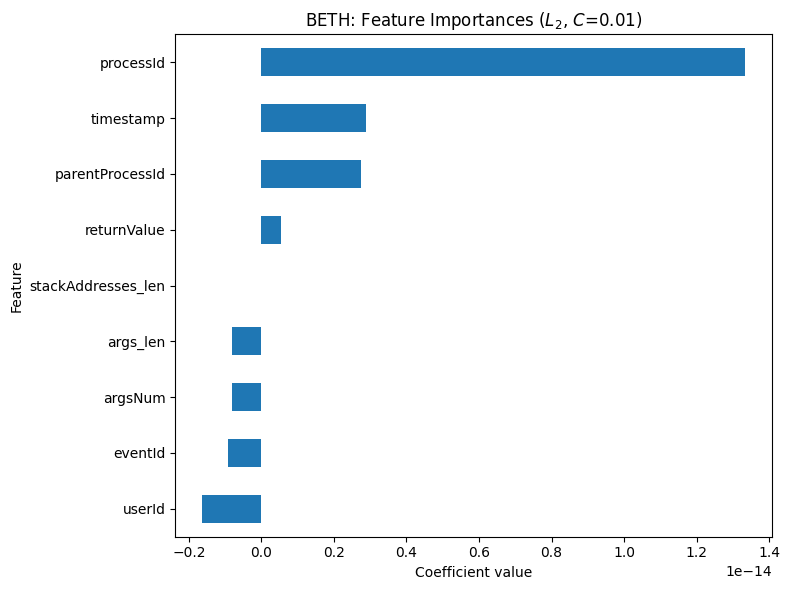

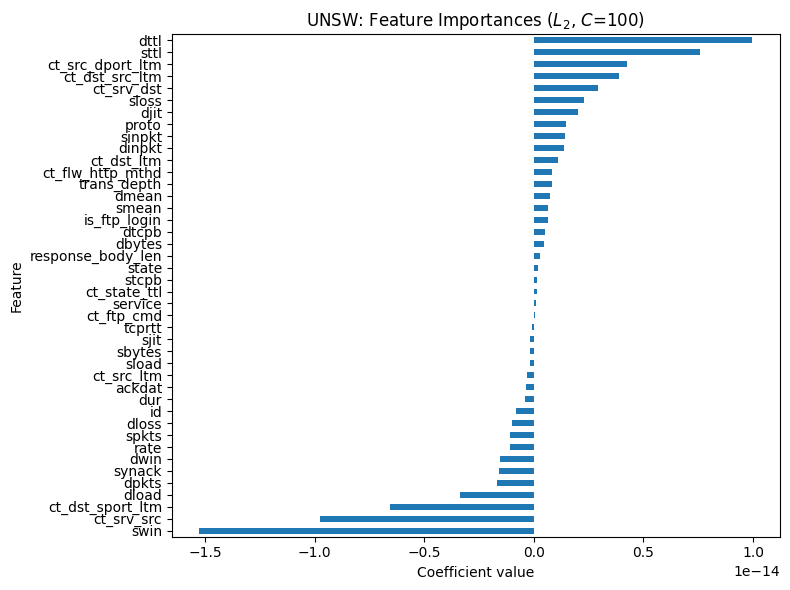

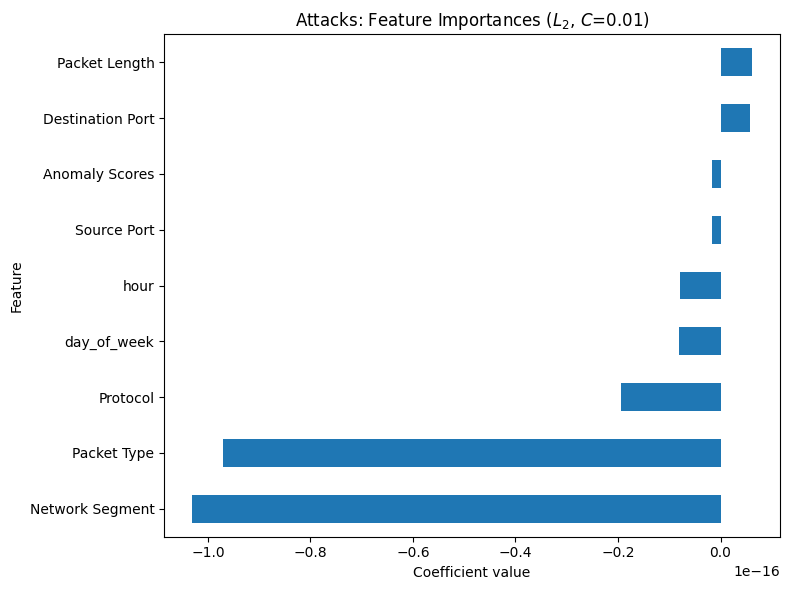

In [7]:
best_Cs = {
    name: pipe.named_steps["clf"].C
    for name, pipe in best_models.items()
}

raw_trains = {
    "BETH":    (X_beth_train,    y_beth_train,    X_beth.columns),
    "UNSW":    (X_unsw_train,    y_unsw_train,    X_unsw.columns),
    "Attacks": (X_attacks_train, y_attacks_train, X_attacks.columns)
}


def plot_raw_coefficients(X_train, y_train, feature_names, C, title):
    """
    Fit a simple pipeline with StandardScaler + LogisticRegression(ℓ₂, C=C),
    then plot the learned coefficient for each original feature.
    """
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf",   LogisticRegression(
            penalty="l2",      # ℓ₂ penalty
            solver="lbfgs",
            C=C,
            max_iter=5000,
            tol=1e-3,
            random_state=42
        ))
    ])
    pipe.fit(X_train, y_train)

    # extract coefficients (average if multiclass)
    coefs = pipe.named_steps["clf"].coef_
    if coefs.ndim > 1:
        coefs = coefs.mean(axis=0)

    # make a Series indexed by your original feature names
    coef_series = pd.Series(coefs, index=feature_names).sort_values()

    # plot
    coef_series.plot.barh(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Coefficient value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    
for name in ["BETH", "UNSW", "Attacks"]:
    X_tr, y_tr, feat_names = raw_trains[name]
    C = best_Cs[name]
    plot_raw_coefficients(
        X_tr,
        y_tr,
        feat_names,
        C,
        f"{name}: Feature Importances ($L_2$, $C$={C})"
    )

### Confusion Matrix Heatmap

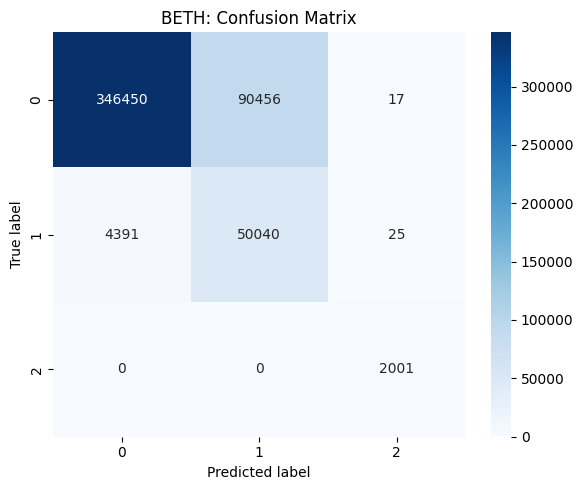

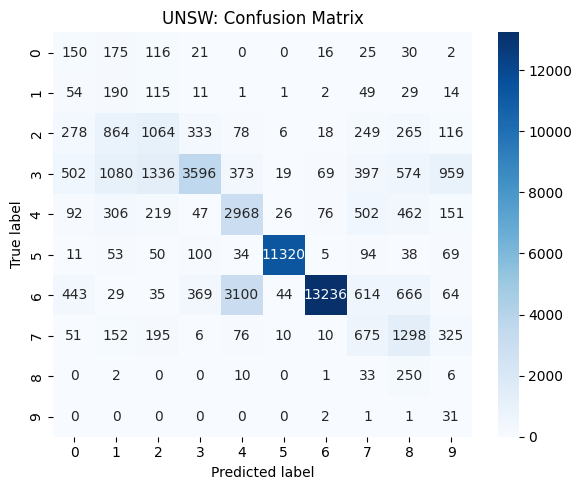

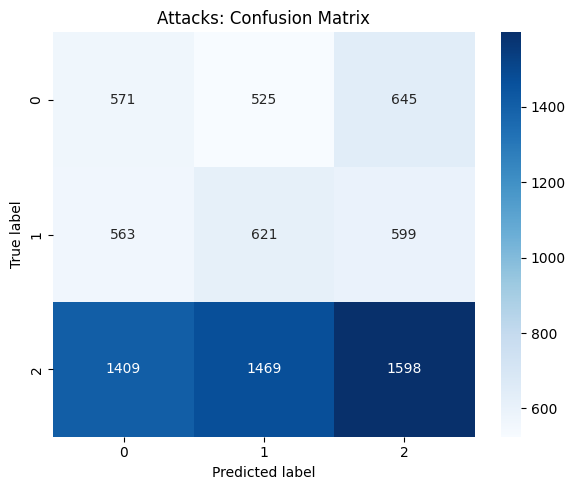

[CV] END ........................................clf__C=0.01; total time=   0.0s
[CV] END ...........................................clf__C=1; total time=   0.0s
[CV] END .........................................clf__C=0.1; total time=   0.0s
[CV] END ........................................clf__C=0.01; total time=   0.0s
[CV] END .........................................clf__C=0.1; total time=   0.0s
[CV] END ..........................................clf__C=10; total time=   0.0s
[CV] END ..........................................clf__C=10; total time=   0.0s
[CV] END ........................................clf__C=0.01; total time=   0.0s
[CV] END ...........................................clf__C=1; total time=   0.0s
[CV] END .........................................clf__C=100; total time=   0.0s
[CV] END .........................................clf__C=0.1; total time=   0.0s
[CV] END ..........................................clf__C=10; total time=   0.0s
[CV] END ...................

In [8]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

for name, model in best_models.items():
    X_test, y_test = datasets[name][2], datasets[name][3]
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, title=f"{name}: Confusion Matrix")

### Logistic Regression Summary Across Datasets

We trained balanced-weight logistic regression models on three datasets using standardized numeric features and tuned the regularization parameter C via stratified 3-fold cross validation.

| Dataset    | Best alpha | CV F1_macro | Test Accuracy | Test F1_macro |
| ---------- | ---------: | ----------: | ------------: | -----------: |
| BETH       | 0.01       | 0.799       | 0.808         | 0.790        |
| UNSW-NB15  | 100        | 0.386       | 0.650         | 0.390        |
| Attacks    | 0.01       | 0.310       | 0.349         | 0.330        |

#### BETH (0 = Benign, 1 = Suspicious, 2 = Malicious)  
- Precision / Recall / F1 by class  
  - Benign: P = 0.99, R = 0.79, F1 = 0.88  
  - Suspicious: P = 0.36, R = 0.92, F1 = 0.51  
  - Malicious: P = 0.98, R = 1.00, F1 = 0.99  
- The model often mislabels Suspicious as Benign suggesting class imbalance needs further handling

#### UNSW-NB15 classes (0 = Analysis, 1 = Backdoor, 2 = DoS, 3 = Exploits, 4 = Fuzzers, 5 = Generic, 6 = Normal, 7 = Reconnaissance, 8 = Shellcode, 9 = Worms)  
- Strong on common classes  
  - Generic: P = 0.99, R = 0.96, F1 = 0.98  
  - Normal: P = 0.99, R = 0.71, F1 = 0.83  
- Poor on rare classes  
  - Analysis: P = 0.09, R = 0.28, F1 = 0.14  
  - Worms: P = 0.02, R = 0.89, F1 = 0.03  
- Confusion matrix shows substantial overlap among minor classes

#### Cybersecurity Attacks (0 = Benign, 1 = Suspicious, 2 = Malicious)  
- Accuracy = 0.349, F1_macro = 0.33  
- Confusion matrix shows misclassification between Benign and Malicious suggesting feature overlap or need for a different model

Tuning the regularization parameter C improved F1_macro over the default. Confusion matrices and class specific metrics show the impact of imbalance. Future work might include resampling or ensemble methods to boost performance on minority classes.  

## Yellowdig Contribution

https://yellowdig.app/n/bu-omds/community/680847e5-a19a-76a7-5e0e-1a1c8b27a7a3?postId=683fafac-9a40-4bd9-b13d-a067e8ff6d99